# Problem 2(c)

## Recurrence relation

This is an example from my [notes on adjoint methods for recurrence relations](http://math.mit.edu/~stevenj/18.336/recurrence2.pdf).

In particular, we have a simple linear recurrence:
$$
x^n = Ax^{n-1} + \begin{pmatrix} 0 \\ p_n \end{pmatrix}
$$
in terms of parameters $p$, with initial condition:
$$
x^0 = b = \begin{pmatrix} 1 \\ 0 \end{pmatrix}
$$
and
$$
A = \begin{pmatrix} \cos\theta & \sin\theta \\ -\sin\theta & \cos\theta \end{pmatrix}
$$
We execute this recurrence for $N$ steps, and at the end we compute $g(p) = (x^N_2)^2$.  In the notes, the goal was to compute the  derivatives $d g / d p_n$ for $n = 1,\ldots,N$.

Now, we want to instead compute $d G / d p_n$ where
$$
G(p,n) = \sum_{n=0}^N g(x^n)
$$
using the modified adjoint recurrence explained in the pset-5 solutions.

In [22]:
θ = 0.1
A = [ cos(θ) sin(θ); -sin(θ) cos(θ)]
N = 100
p = [1,2,3,4,5]
b = [1,0]

2-element Array{Int64,1}:
 1
 0

In [4]:
# compute G by the recurrence
function recurrence(A, b, p)
    x = b
    G = x[2]^2
    for i = 1:length(p)
        x = A * x + [0,p[i]]
        G += x[2]^2
    end
    return G
end

recurrence (generic function with 1 method)

In [19]:
recurrence(A, b, p)

334.995658997325

Here is the implementation of $G$ and $dG/dp$ by the adjoint method, as explained in the notes.   This involves computing the recurrence "forward" to obtain $x^n$, *saving* the results for each $n$ (using a $2\times N+1$ matrix `X` here), then computing the adjoint recurrence "backward" to obtain $\lambda$ and accumulate $dG/dp$.

In [8]:
# compute G(x) = ∑ x[2]^2, and dG/dp, by adjoint method
function recurrence_adjoint(A, b, p)
    X = Array(Float64, 2, length(p)+1)
    X[:,1] = b
    G = X[2,1]^2
    for i = 1:length(p)
        X[:,i+1] = A * X[:,i] + [0,p[i]]
        G += X[2,i+1]^2
    end
    λ = [0, 2*X[2,end]]
    dGdp = Array(Float64, length(p))
    for i = length(p):-1:1
        dGdp[i] = λ[2]
        λ = A'λ + [0, 2*X[2,i]]
    end
    return G, dGdp
end

recurrence_adjoint (generic function with 1 method)

In [20]:
recurrence_adjoint(A, b, p)

(334.995658997325,[62.952210001400694,62.798159815366446,58.25225472582998,47.42457090302371,28.545049656571447])

For comparison, we will compute $dG/dp$ by a center difference approximation: $\partial G/\partial p_n \approx [G(p + e_n\delta ) - G(p - e_n\delta )] / 2\delta$ for some small $\delta$.

In [31]:
function recurrence_FD(A, b, p, δ=1e-5)
    G = recurrence(A, b, p)
    dGdp = Array(Float64, length(p))
    p′ = copy!(similar(p, Float64), p) # modify a copy of p rather than p
    for i = 1:length(p)
        p′[i] = p[i] + δ
        G₊ = recurrence(A, b, p′)
        p′[i] = p[i] - δ
        G₋ = recurrence(A, b, p′)
        dGdp[i] = (G₊ - G₋) / (2δ)
        p′[i] = p[i]
    end
    return G, dGdp
end

recurrence_FD (generic function with 2 methods)

As we might have hoped, the answers are pretty close (limited by roundoff error and/or finite-difference error):

In [32]:
norm(recurrence_FD(A, b, p)[2] - recurrence_adjoint(A, b, p)[2])

7.579243788848227e-9

In practice, it is really easy to make mistakes in computing derivatives of complicated functions by hand, so it is always important to check your results against a finite-difference approximation.

It is interesting to ask what the influence of the finite-difference step $\delta$ is in this problem, by plotting the error vs. $\delta$:

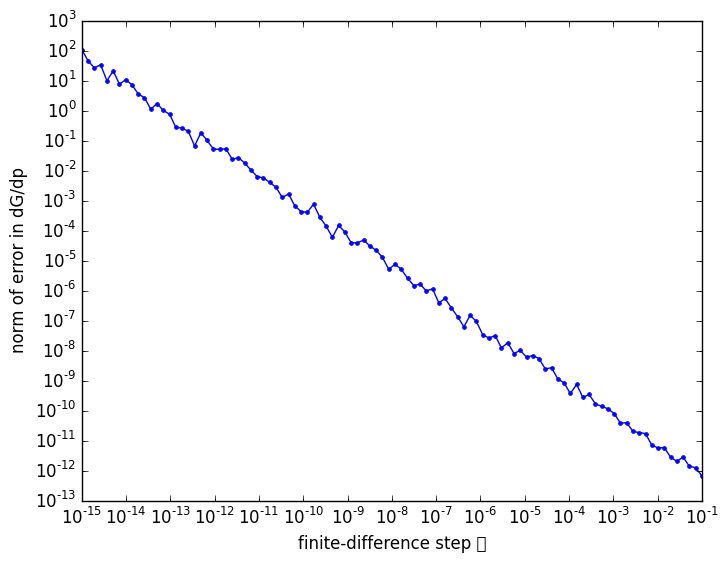

PyObject <matplotlib.text.Text object at 0x32054a190>

In [33]:
using PyPlot
δ = logspace(-15, -1, 100)
loglog(δ, [norm(recurrence_adjoint(A, b, p)[2] - recurrence_FD(A, b, p, d)[2]) for d in δ], ".-")
xlabel("finite-difference step δ")
ylabel("norm of error in dG/dp")

At first glance, this seems ridiculous: the errors get *monotonically worse* as $\delta$ decreases!  How can this be right?

The key point is to realize that our $G(p)$ depends *quadratically* on $p$, and a center-difference approximation is *exact* for a quadratic function *in exact arithmetic*.   So, *all* of the difference arises due to roundoff errors.  In the finite-difference approximation, the difference $G(p + e_n\delta) - G(p - e_n\delta)$ is the difference of two nearly equal quantities as $\delta \to 0$, so there is a large cancellation error in the result (i.e. the result arises from the *least* significant digits of $G$), and hence the error worsens with decreasing $\delta$.